In [2]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import mido
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from pretty_midi import PrettyMIDI
import midi_utils as mu
#import scales

In [19]:
MIDI_FOLDER = "MIDI_Files/"

# filename = "KCP_Major_1.mid"
# filename = "Under-The-Sea.mid"
filename = "Wii Channels - Mii Channel.mid"
# filename = "mii_channel_reexported.mid"
# filename = "test_piano.mid"
m = mido.MidiFile(filename=MIDI_FOLDER + filename)
print("MIDI Type:", m.type)
# print(m.print_tracks())
mido.MidiTrack.mro
print(m.tracks[0])

MIDI Type: 1
MidiTrack([
  MetaMessage('smpte_offset', frame_rate=25, hours=32, minutes=0, seconds=0, frames=0, sub_frames=0, time=0),
  MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
  MetaMessage('key_signature', key='A', time=0),
  MetaMessage('set_tempo', tempo=499999, time=0),
  MetaMessage('set_tempo', tempo=500003, time=0),
  MetaMessage('set_tempo', tempo=499999, time=0),
  MetaMessage('set_tempo', tempo=500003, time=0),
  MetaMessage('set_tempo', tempo=500003, time=43008),
  MetaMessage('set_tempo', tempo=504434, time=256),
  MetaMessage('set_tempo', tempo=506432, time=256),
  MetaMessage('set_tempo', tempo=508697, time=256),
  MetaMessage('set_tempo', tempo=513029, time=256),
  MetaMessage('set_tempo', tempo=515093, time=256),
  MetaMessage('set_tempo', tempo=517436, time=256),
  MetaMessage('set_tempo', tempo=519535, time=256),
  MetaMessage('set_tempo', tempo=500003, time=512),
  MetaMessage('set_tempo'

In [7]:
music = PrettyMIDI(midi_file=filename)
bla = music.synthesize(fs=22050)
#sd.play(bla, 22050)

In [10]:
print(bla[40000:50000])

[0.10166189 0.0689509  0.03423324 ... 0.21903337 0.23873299 0.25543585]


In [103]:

def track_to_dataframe(track, event_style=False):
    records = []
    track_name = ""
    current_time = 0
    # Event style dataframe
    if event_style:
        for x in track:
            new_dict = x.__dict__.copy()
            if not x.is_meta():
                #Swapping name for coherence
                new_dict["time_diff"] = new_dict["time"] 
                current_time += new_dict["time_diff"]
                new_dict["time"] = current_time
                new_dict["pressed"] = new_dict["type"] == "note_on"
                new_dict["released"] = new_dict["type"] == "note_off"
                records.append(new_dict)
    else:
        # Streaming style dataframe
        pressed_notes = {}
        id = 0
        for x in track:
            new_dict = x.__dict__.copy()
            if new_dict["type"] == "track_name":
                track_name = new_dict["name"]
            else:
                current_time += new_dict["time"]
                new_dict["time"] = current_time
                new_dict["time_release"] = None
                new_dict["time_duration"] = None
                new_dict["velocity_release"] = None
                if new_dict["type"] == "note_off":
                    former_pressed_note = pressed_notes[new_dict["note"]]
                    if former_pressed_note is None:
                        raise ValueError("The given track has a released note that was never pressed in the first place")
                    pressed_record = records[former_pressed_note["id"]]
                    pressed_record["time_release"] = current_time
                    pressed_record["time_duration"] = current_time - pressed_record["time"]
                    pressed_record["velocity_release"] = new_dict["velocity"]
                    pressed_notes[new_dict["note"]] = None
                elif new_dict["type"] == "note_on":
                    pressed_notes[new_dict["note"]] = {"id": id}
                    del new_dict["type"]
                    records.append(new_dict)
                    id += 1
                                        
    return pd.DataFrame(records)

pd_track = track_to_dataframe(m.tracks[1])
print(pd_track)

       time  note  velocity  channel  time_release  time_duration  \
0        10    62        59        0           439            429   
1        10    66        73        0           439            429   
2        10    47        67        0           439            429   
3      1054    66        55        0          1251            197   
4      1054    69        69        0          1251            197   
..      ...   ...       ...      ...           ...            ...   
539  203283    59        52        0        203480            197   
540  203788    64        55        0        204185            397   
541  203788    68        65        0        204185            397   
542  203788    49        55        0        204185            397   
543  203788    59        65        0        204185            397   

     velocity_release  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
539

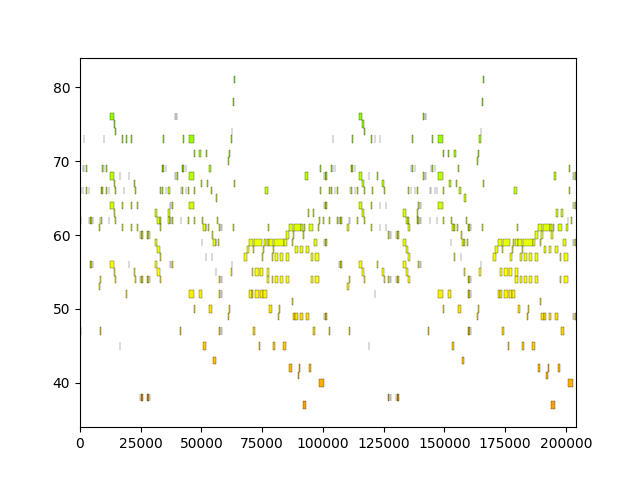

In [5]:
def plot_music(scheduled_style_df: pd.DataFrame, chroma_plot=False, ax=None, cmap=plt.get_cmap("gist_rainbow")):
    if ax is None:
        _, ax = plt.subplots()
    
    df_copy = scheduled_style_df[["time", "note", "time_duration", "time_release"]]
    if chroma_plot:
        df_copy.loc[:, "note"] = mu.to_chroma(df_copy["note"])
    for i, x in df_copy.iterrows():
        rect = patches.Rectangle((x.time, x.note - 0.5), width=x.time_duration, height=1, linewidth=0.2, edgecolor=(0,0,0), facecolor=cmap(x.note))
        ax.add_patch(rect)
    plt.xlim(0, df_copy.time_release.max())
    plt.ylim(df_copy.note.min() - 3, df_copy.note.max() + 3)

plot_music(pd_track, chroma_plot=False)

In [7]:
midi_ids = pd_track.note.to_numpy()

# Transposition:
transposition = 0
midi_ids += (transposition%12)

# general_scale_subset = scales.create_general_scale_subset()
general_scale_subset = scales.create_general_scale_subset(note_counts=[5,7])

print(len(general_scale_subset), "general scales will be examined")
music_note_count = len(midi_ids)
print("Music note count:", music_note_count)
window_size = max(int(music_note_count * 0.1), 14)
print("Window size:", window_size)

print(scales.windowed_suggest_scales(midi_ids, threshold=0.9, window_size=window_size, window_threshold=0.9, general_scale_subset=general_scale_subset))

101 general scales will be examined
Music note count: 544
Window size: 54
{Lydian Scale in G: 1.0, Phrygian Scale in F#/Gb: 1.0, Locrian Scale in C#/Db: 1.0, Major Scale in D: 1.0}
